CSC 180 Intelligent Systems (Fall 2021)

#**Module 1**

Useful function definitions

##3.2.1 Algorithm Description (Algorithm A for Module 1)  

In [ ]:
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)



# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['pred'].tolist(),label='prediction')
    b = plt.plot(t['y'].tolist(),label='expected')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low

#**3.3 Module 2**

Data manipulation


##3.3.1 Algorithm Description (Algorithm A for Module 2) 

Imports specific Google drive, so that the data can be accessed 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##3.3.2 Algorithm Description (Algorithm A for Module 2) 

Reads the Amazon reviews subset JSON file in

In [ ]:
import json
import csv
import pandas as pd

#This code Imports the Amazon ALL_Beauty review data from Gdrive
df_All_Beauty = pd.read_json('/content/drive/MyDrive/Colab Notebooks/Final Project/All_Beauty.json', encoding="utf-8", lines=True)
df_All_Beauty

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,1,True,"02 19, 2015",A1V6B6TNIC10QE,0143026860,theodore j bigham,great,One Star,1424304000,NaN,NaN,NaN
1,4,True,"12 18, 2014",A2F5GHSXFQ0W6J,0143026860,Mary K. Byke,My husband wanted to reading about the Negro ...,... to reading about the Negro Baseball and th...,1418860800,NaN,NaN,NaN
2,4,True,"08 10, 2014",A1572GUYS7DGSR,0143026860,David G,"This book was very informative, covering all a...",Worth the Read,1407628800,NaN,NaN,NaN
3,5,True,"03 11, 2013",A1PSGLFK1NSVO,0143026860,TamB,I am already a baseball fan and knew a bit abo...,Good Read,1362960000,NaN,NaN,NaN
4,5,True,"12 25, 2011",A6IKXKZMTKGSC,0143026860,shoecanary,This was a good story of the Black leagues. I ...,"More than facts, a good story read!",1324771200,5,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
371340,1,True,"07 20, 2017",A202DCI7TV1022,B01HJEGTYK,Sam,It was awful. It was super frizzy and I tried ...,It was super frizzy and I tried to comb it and...,1500508800,NaN,NaN,NaN
371341,5,True,"03 16, 2017",A3FSOR5IJOFIBE,B01HJEGTYK,TYW,I was skeptical about buying this. Worried it...,Awesome,1489622400,34,NaN,NaN
371342,5,True,"03 1, 2017",A1B5DK6CTP2P24,B01HJEGTYK,Norma Jennings,Makes me look good fast.,Five Stars,1488326400,46,NaN,NaN
371343,2,True,"02 21, 2017",A23OUYS5IRMJS9,B01HJEGTYK,Lee,Way lighter than photo\nNot mix blend of color...,Ok but color way off and volume as well,1487635200,NaN,NaN,NaN


##3.3.3 Algorithm Description 

Removes unnecessary columns from subset dataframe

In [ ]:
df_All_Beauty = df_All_Beauty.drop(columns=['verified','reviewTime','reviewerID','asin','reviewerName','style'])
df_All_Beauty

,overall,reviewText,summary,unixReviewTime,vote,image
0,1,great,One Star,1424304000,NaN,NaN
1,4,My husband wanted to reading about the Negro ...,... to reading about the Negro Baseball and th...,1418860800,NaN,NaN
2,4,"This book was very informative, covering all a...",Worth the Read,1407628800,NaN,NaN
3,5,I am already a baseball fan and knew a bit abo...,Good Read,1362960000,NaN,NaN
4,5,This was a good story of the Black leagues. I ...,"More than facts, a good story read!",1324771200,5,NaN
...,...,...,...,...,...,...
371340,1,It was awful. It was super frizzy and I tried ...,It was super frizzy and I tried to comb it and...,1500508800,NaN,NaN
371341,5,I was skeptical about buying this. Worried it...,Awesome,1489622400,34,NaN
371342,5,Makes me look good fast.,Five Stars,1488326400,46,NaN
371343,2,Way lighter than photo\nNot mix blend of color...,Ok but color way off and volume as well,1487635200,NaN,NaN


##3.3.4 Algorithm Description (Algorithm D for Module 2)

Changes image column to has image or doesn't have image 0/1

Fills empty values with 0 in overall

Removes all rows containing 0 upvotes

Adds summary test to reviewText column


In [ ]:
df_All_Beauty.loc[df_All_Beauty['image'].notnull(), 'image'] = 1
df_All_Beauty['image'] = df_All_Beauty['image'].fillna(0)
df_All_Beauty['overall'] = df_All_Beauty['overall'].fillna(0)
df_All_Beauty['vote'] = df_All_Beauty['vote'].str.replace(',', '').astype(float)
#df_All_Beauty['vote'] = df_All_Beauty['vote'].fillna(0)
df_All_Beauty = df_All_Beauty.dropna()

df_All_Beauty['reviewText'] = df_All_Beauty['reviewText'] + df_All_Beauty['summary']
df_All_Beauty = df_All_Beauty.drop(columns=['summary'])


df_All_Beauty

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,overall,reviewText,unixReviewTime,vote,image
4,5,This was a good story of the Black leagues. I ...,1324771200,5.0,0
5,5,Today I gave a book about the Negro Leagues of...,1267142400,4.0,0
6,4,The story of race relations in American histor...,983923200,14.0,0
9,1,it burns your eyes when u put it on and very ...,1479513600,3.0,0
12,4,purchased for vending resale at bellydance wee...,1470355200,5.0,0
...,...,...,...,...,...
371303,4,"This watch, for the very cheap price, is a rid...",1487548800,4.0,0
371327,5,You need this if of you have Benefit's Eye Bri...,1510617600,2.0,0
371335,1,"These legitimately look used, like they repack...",1472601600,3.0,1
371341,5,I was skeptical about buying this. Worried it...,1489622400,34.0,0


##3.3.5 Algorithm Description (Algorithm E for Module 2)

Removes outliers from dataframe

In [ ]:
print(df_All_Beauty['vote'].min())
print(df_All_Beauty['vote'].max())
remove_outliers(df_All_Beauty, 'vote',1)
print(df_All_Beauty['vote'].min())
print(df_All_Beauty['vote'].max())
df_All_Beauty

2.0
2721.0
2.0
42.0


,overall,reviewText,unixReviewTime,vote,image
4,5,This was a good story of the Black leagues. I ...,1324771200,5.0,0
5,5,Today I gave a book about the Negro Leagues of...,1267142400,4.0,0
6,4,The story of race relations in American histor...,983923200,14.0,0
9,1,it burns your eyes when u put it on and very ...,1479513600,3.0,0
12,4,purchased for vending resale at bellydance wee...,1470355200,5.0,0
...,...,...,...,...,...
371302,5,Great looking watch. Yellow stiching on leath...,1502409600,3.0,0
371303,4,"This watch, for the very cheap price, is a rid...",1487548800,4.0,0
371327,5,You need this if of you have Benefit's Eye Bri...,1510617600,2.0,0
371335,1,"These legitimately look used, like they repack...",1472601600,3.0,1


##3.3.6 Algorithm Description (Algorithm F for Module 2)

Normalizes the vote column of the dataframe

In [ ]:
encode_numeric_range(df_All_Beauty,'vote', 0, 1)
print(df_All_Beauty['vote'].min())
print(df_All_Beauty['vote'].max())
df_All_Beauty

0.0
1.0


,overall,reviewText,unixReviewTime,vote,image
4,5,This was a good story of the Black leagues. I ...,1324771200,0.075,0
5,5,Today I gave a book about the Negro Leagues of...,1267142400,0.050,0
6,4,The story of race relations in American histor...,983923200,0.300,0
9,1,it burns your eyes when u put it on and very ...,1479513600,0.025,0
12,4,purchased for vending resale at bellydance wee...,1470355200,0.075,0
...,...,...,...,...,...
371302,5,Great looking watch. Yellow stiching on leath...,1502409600,0.025,0
371303,4,"This watch, for the very cheap price, is a rid...",1487548800,0.050,0
371327,5,You need this if of you have Benefit's Eye Bri...,1510617600,0.000,0
371335,1,"These legitimately look used, like they repack...",1472601600,0.025,1


##3.3.7 Algorithm Description (Algorithm G for Module 2)

Transforms the reviewText column into TF-IDF

In [ ]:
import sklearn.feature_extraction.text as sk_text

vocab_size = 1000

vectorizer = sk_text.TfidfVectorizer(stop_words='english',
                             max_features = vocab_size,
                             min_df=10, 
                             #max_df=100
                             )

#min_df: ignore terms that have a document frequency < min_df.
#max_df: ignore terms that have a document frequency > max_df

matrix = vectorizer.fit_transform(df_All_Beauty.reviewText)

tfidf_data = matrix.toarray()     #  convert it to numpy array

print(tfidf_data)
print(tfidf_data.shape)
print(vectorizer.get_feature_names_out())

Tf_data = pd.DataFrame()

print(len(vectorizer.get_feature_names_out()))

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.24615002]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
(50786, 1000)
['00' '10' '100' '12' '15' '20' '25' '30' '40' '50' '60' 'able'
 'absolutely' 'acid' 'acne' 'actual' 'actually' 'add' 'added' 'addition'
 'advertised' 'age' 'aging' 'ago' 'air' 'alcohol' 'allergic' 'aloe'
 'alternative' 'amazing' 'amazon' 'anti' 'anymore' 'apart' 'appearance'
 'application' 'applied' 'apply' 'applying' 'area' 'areas' 'aren' 'argan'
 'arms' 'arrived' 'ask' 'asked' 'available' 'avoid' 'away' 'awesome'
 'awful' 'baby' 'bad' 'bag' 'bar' 'barely' 'bars' 'base' 'based'
 'basically' 'bath' 'bathroom' 'batteries' 'battery' 'bea

#Module 3

TF-IDF prediction Model

##3.4.1 Algorithm Description (Algorithm A for Module 3)

Prepares test train split

Creates checkpoint

defines model and loops with early stopping

Loads best model from checkpoint

Then produces regression chart

0
Epoch 1/200
1270/1270 - 5s - loss: 0.0179 - accuracy: 0.3840 - val_loss: 0.0194 - val_accuracy: 0.3945 - 5s/epoch - 4ms/step
Epoch 2/200
1270/1270 - 4s - loss: 0.0164 - accuracy: 0.3840 - val_loss: 0.0198 - val_accuracy: 0.3945 - 4s/epoch - 3ms/step
Epoch 3/200
1270/1270 - 4s - loss: 0.0116 - accuracy: 0.3843 - val_loss: 0.0205 - val_accuracy: 0.3945 - 4s/epoch - 3ms/step
Epoch 4/200
1270/1270 - 4s - loss: 0.0063 - accuracy: 0.3845 - val_loss: 0.0201 - val_accuracy: 0.3941 - 4s/epoch - 3ms/step
Epoch 5/200
1270/1270 - 4s - loss: 0.0039 - accuracy: 0.3845 - val_loss: 0.0206 - val_accuracy: 0.3945 - 4s/epoch - 3ms/step
Epoch 6/200
1270/1270 - 4s - loss: 0.0027 - accuracy: 0.3846 - val_loss: 0.0209 - val_accuracy: 0.3944 - 4s/epoch - 3ms/step
Epoch 00006: early stopping
1
Epoch 1/200
1270/1270 - 5s - loss: 0.0179 - accuracy: 0.3840 - val_loss: 0.0197 - val_accuracy: 0.3945 - 5s/epoch - 4ms/step
Epoch 2/200
1270/1270 - 4s - loss: 0.0166 - accuracy: 0.3840 - val_loss: 0.0200 - val_accurac

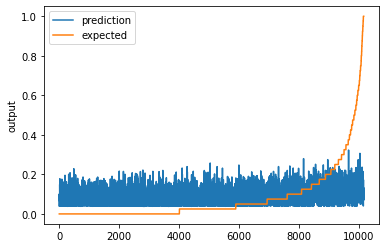

In [ ]:
%matplotlib inline
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import os
from sklearn import metrics
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

# Encode to a 2D matrix for training
x = tfidf_data
y = df_All_Beauty['vote'].to_numpy()

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

# Define ModelCheckpoint outside the loop
checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=0, save_best_only=True) # save best model


for i in range(5):
    print(i)
    
    model = Sequential()
    model.add(Dense(1000, input_dim=x.shape[1], activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=5, verbose=1, mode='auto')

    model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=200)

print('Training finished...Loading the best model')  
print()
model.load_weights('dnn/best_weights.hdf5') # load weights from best model

# Predict and measure RMSE
pred = model.predict(x_test)

score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

# Plot the chart
chart_regression(pred.flatten(),y_test, sort=True)

##3.4.2 Algorithm Description (Algorithm B for Module 3)

Produces a regression chart for training data

Score (RMSE): 0.1277255153365108
Model: "sequential_102"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_432 (Dense)           (None, 1000)              1001000   
                                                                 
 dense_433 (Dense)           (None, 100)               100100    
                                                                 
 dense_434 (Dense)           (None, 100)               10100     
                                                                 
 dense_435 (Dense)           (None, 100)               10100     
                                                                 
 dense_436 (Dense)           (None, 20)                2020      
                                                                 
 dense_437 (Dense)           (None, 1)                 21        
                                                                 
Total params: 1,123

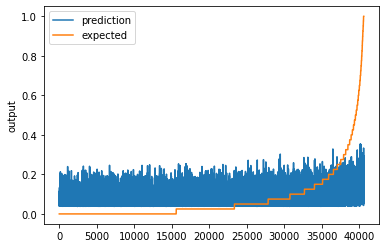

In [ ]:
# Predict and measure RMSE
pred = model.predict(x_train)

score = np.sqrt(metrics.mean_squared_error(pred,y_train))
print("Score (RMSE): {}".format(score))

# summarize the model
print(model.summary())

score = np.sqrt(metrics.mean_squared_error(pred,y_train))
print("Score (RMSE): {}".format(score))

# Plot the chart
chart_regression(pred.flatten(),y_train, sort=True)

#**3.5 Module 4**
TF-IDF model with word embedding


##3.5.1 Algorithm Description (Algorithm A for Module 4)

Prepares test train split

Creates checkpoint

defines model and loops with early stopping

Loads best model from checkpoint

Then produces regression chart

0
Epoch 1/200
1270/1270 - 6s - loss: 1.1478 - accuracy: 0.3471 - val_loss: 1.1878 - val_accuracy: 0.3945 - 6s/epoch - 5ms/step
Epoch 2/200
1270/1270 - 6s - loss: 1.1773 - accuracy: 0.3840 - val_loss: 1.1878 - val_accuracy: 0.3945 - 6s/epoch - 5ms/step
Epoch 3/200
1270/1270 - 6s - loss: 1.1773 - accuracy: 0.3840 - val_loss: 1.1878 - val_accuracy: 0.3945 - 6s/epoch - 4ms/step
Epoch 4/200
1270/1270 - 6s - loss: 1.1773 - accuracy: 0.3840 - val_loss: 1.1878 - val_accuracy: 0.3945 - 6s/epoch - 4ms/step
Epoch 5/200
1270/1270 - 6s - loss: 1.1773 - accuracy: 0.3840 - val_loss: 1.1878 - val_accuracy: 0.3945 - 6s/epoch - 5ms/step
Epoch 6/200
1270/1270 - 6s - loss: 1.1773 - accuracy: 0.3840 - val_loss: 1.1878 - val_accuracy: 0.3945 - 6s/epoch - 4ms/step
Epoch 00006: early stopping
1
Epoch 1/200
1270/1270 - 6s - loss: 0.8709 - accuracy: 8.8609e-04 - val_loss: 0.8668 - val_accuracy: 0.0013 - 6s/epoch - 5ms/step
Epoch 2/200
1270/1270 - 6s - loss: 0.8715 - accuracy: 5.9073e-04 - val_loss: 0.8668 - val

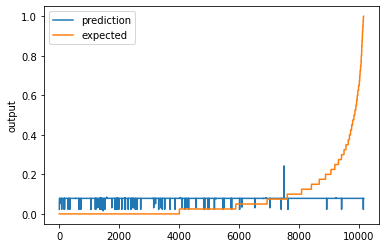

In [ ]:
%matplotlib inline
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
from sklearn import metrics
import pandas as pd
import numpy as np
from numpy import array
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Embedding, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
#from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import pad_sequences

x = tfidf_data
y = df_All_Beauty['vote'].to_numpy()

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

# Define ModelCheckpoint outside the loop
checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(5):
    print(i)

    # define the model
    model = Sequential()
    model.add(Embedding(vocab_size, 100, input_length=vocab_size))
    model.add(Flatten())
    #model.add(Dense(20, activation='relu'))
    #model.add(Dense(100, activation='relu'))
    #model.add(Dense(100, activation='relu'))
    #model.add(Dense(100, activation='relu'))
    #model.add(Dense(20, activation='relu'))
    model.add(Dense(1, activation='tanh'))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
    
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    # fit the model
    model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=200)

print('Training finished...Loading the best model')  
print()
model.load_weights('dnn/best_weights.hdf5') # load weights from best model


# Predict and measure RMSE
pred = model.predict(x_test)

score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

# summarize the model
print(model.summary())

score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

# Plot the chart
chart_regression(pred.flatten(),y_test, sort=True)

##3.5.2 Algorithm Description (Algorithm B for Module 4)

Produces a regression chart for training data

Score (RMSE): 0.13612521955791507
Model: "sequential_115"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_109 (Embedding)   (None, 1000, 100)         100000    
                                                                 
 flatten_107 (Flatten)       (None, 100000)            0         
                                                                 
 dense_484 (Dense)           (None, 1)                 100001    
                                                                 
Total params: 200,001
Trainable params: 200,001
Non-trainable params: 0
_________________________________________________________________
None
Score (RMSE): 0.13612521955791507


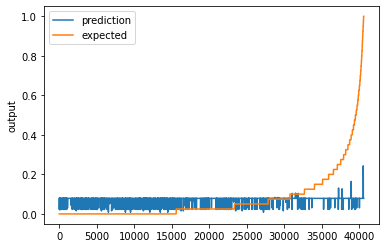

In [ ]:
# Predict and measure RMSE
pred = model.predict(x_train)

score = np.sqrt(metrics.mean_squared_error(pred,y_train))
print("Score (RMSE): {}".format(score))

# summarize the model
print(model.summary())

score = np.sqrt(metrics.mean_squared_error(pred,y_train))
print("Score (RMSE): {}".format(score))

# Plot the chart
chart_regression(pred.flatten(),y_train, sort=True)

#**3.6 Module 5**

GloVe pre-trained word embedding model

##3.6.1 Algorithm Description (Algorithm A for Module 5)

Prepares uses tokenizer to fit dataframe's reviewText column

Encodes reviewText column

Loads in GloVe pre-trained model

Creates weight matrix 

In [ ]:
%matplotlib inline
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
from sklearn import metrics
import pandas as pd
import numpy as np
from numpy import array
from numpy import asarray
from numpy import zeros
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Embedding, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

text = df_All_Beauty['reviewText']
demensions = 300

# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(text)
vocab_size = len(t.word_index) + 1

# integer encode the documents
encoded_docs = t.texts_to_sequences(text)
print(encoded_docs)

# pad documents to a max length of 4 words
max_length = 30
x = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(x)

y = df_All_Beauty['vote'].to_numpy()

# load the whole embedding into memory
embeddings_index = dict()
f = open('/content/drive/MyDrive/Colab Notebooks/Final Project/glove.6B.300d.txt')
for line in f:
	values = line.split()
	word = values[0]
	coefs = array(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

# create a weight matrix for words in training docs
embedding_matrix = zeros((vocab_size, demensions))
for word, i in t.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[[ 1932  1166     5 ...    41  2114   349]
 [   50   442  4630 ...    10   442  7420]
 [    1 10991  7420 ...  5188     3 20209]
 ...
 [  152     5   810 ...    77    77    60]
 [   62 23593   133 ...     0     0     0]
 [  706    20   413 ...    58   435   340]]
Loaded 400001 word vectors.


##3.6.2 Algorithm Description (Algorithm B for Module 5)


Prepares test train split

Creates checkpoint

defines model and loops with early stopping

Loads best model from checkpoint

Then produces regression chart


0
Epoch 1/200
1270/1270 - 5s - loss: 0.0186 - accuracy: 0.3840 - val_loss: 0.0208 - val_accuracy: 0.3945 - 5s/epoch - 4ms/step
Epoch 2/200
1270/1270 - 4s - loss: 0.0177 - accuracy: 0.3840 - val_loss: 0.0203 - val_accuracy: 0.3945 - 4s/epoch - 3ms/step
Epoch 3/200
1270/1270 - 4s - loss: 0.0147 - accuracy: 0.3841 - val_loss: 0.0209 - val_accuracy: 0.3946 - 4s/epoch - 3ms/step
Epoch 4/200
1270/1270 - 4s - loss: 0.0107 - accuracy: 0.3844 - val_loss: 0.0205 - val_accuracy: 0.3946 - 4s/epoch - 3ms/step
Epoch 5/200
1270/1270 - 4s - loss: 0.0085 - accuracy: 0.3845 - val_loss: 0.0208 - val_accuracy: 0.3944 - 4s/epoch - 3ms/step
Epoch 6/200
1270/1270 - 4s - loss: 0.0072 - accuracy: 0.3845 - val_loss: 0.0212 - val_accuracy: 0.3946 - 4s/epoch - 3ms/step
Epoch 00006: early stopping
1
Epoch 1/200
1270/1270 - 5s - loss: 0.0186 - accuracy: 0.3840 - val_loss: 0.0206 - val_accuracy: 0.3945 - 5s/epoch - 4ms/step
Epoch 2/200
1270/1270 - 4s - loss: 0.0175 - accuracy: 0.3840 - val_loss: 0.0208 - val_accurac

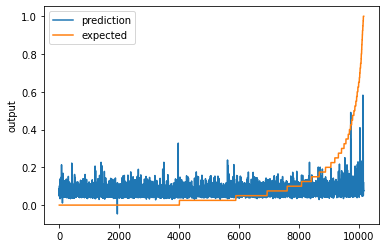

In [ ]:
# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

# Define ModelCheckpoint outside the loop
checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(5):
    print(i)

    # define the model
    model = Sequential()
    model.add(Embedding(vocab_size, demensions, weights=[embedding_matrix], input_length=max_length, trainable=False))
    model.add(Flatten())
    #model.add(Dropout(0.5))
    #model.add(Dense(150, activation='relu'))
    #model.add(Dropout(0.5))
    #model.add(Dense(100, activation='relu'))
    #model.add(Dropout(0.5))
    #model.add(Dense(50, activation='relu'))
    #model.add(Dropout(0.5))
    model.add(Dense(75, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(75, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(1, activation='tanh'))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
    
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    # fit the model
    model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=200)

print('Training finished...Loading the best model')  
print()
model.load_weights('dnn/best_weights.hdf5') # load weights from best model


# Predict and measure RMSE
pred = model.predict(x_test)

score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

# summarize the model
print(model.summary())

score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

# Plot the chart
chart_regression(pred.flatten(),y_test, sort=True)

##3.6.3 Algorithm Description (Algorithm C for Module 5)

Produces a regression chart for training data

Score (RMSE): 0.12044499262602495
Model: "sequential_120"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_114 (Embedding)   (None, 30, 300)           14736900  
                                                                 
 flatten_112 (Flatten)       (None, 9000)              0         
                                                                 
 dense_513 (Dense)           (None, 75)                675075    
                                                                 
 dense_514 (Dense)           (None, 50)                3800      
                                                                 
 dense_515 (Dense)           (None, 25)                1275      
                                                                 
 dense_516 (Dense)           (None, 75)                1950      
                                                                 
 dense_517 (Dense)

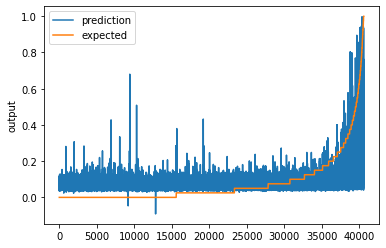

In [ ]:
# Predict and measure RMSE
pred = model.predict(x_train)

score = np.sqrt(metrics.mean_squared_error(pred,y_train))
print("Score (RMSE): {}".format(score))

# summarize the model
print(model.summary())

score = np.sqrt(metrics.mean_squared_error(pred,y_train))
print("Score (RMSE): {}".format(score))

# Plot the chart
chart_regression(pred.flatten(),y_train, sort=True)